In [147]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
df = pd.read_csv('covid.csv')

In [148]:
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d', errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['start_date', 'end_date'])

# Выбор региона с большим количеством данных, например США
selected_region = 'United States'
region_df = df[df['region'] == selected_region].copy()
region_df = region_df.drop(columns=['total_deaths'])
print(region_df.head())

            country         region  region_code start_date   end_date  days  \
5642  United States  United States            0 2019-12-30 2020-01-05     7   
5643  United States  United States            0 2020-01-06 2020-01-12     7   
5644  United States  United States            0 2020-01-13 2020-01-19     7   
5645  United States  United States            0 2020-01-20 2020-01-26     7   
5646  United States  United States            0 2020-01-27 2020-02-02     7   

      year  week  population  covid_deaths  expected_deaths  excess_deaths  \
5642  2020     1   336997624             0     62231.057203   -2051.057203   
5643  2020     2   336997624             0     62611.057203   -1874.057203   
5644  2020     3   336997624             0     61117.723870   -1751.723870   
5645  2020     4   336997624             0     60353.890537   -1189.890537   
5646  2020     5   336997624             0     60022.723870   -1187.723870   

      non_covid_deaths  covid_deaths_per_100k  excess_de

In [150]:
region_df['rolling_mean_7'] = region_df['covid_deaths_per_100k'].shift(1).rolling(window=7).mean()
region_df['ewm_mean_7'] = region_df['covid_deaths_per_100k'].shift(1).ewm(span=7).mean()
region_df['lag_1'] = region_df['covid_deaths_per_100k'].shift(1)
region_df['lag_7'] = region_df['covid_deaths_per_100k'].shift(7)

# Удаление строк с пропущенными значениями после создания новых признаков
region_df = region_df.dropna()

# Проверка данных после создания признаков
print(region_df[['start_date', 'covid_deaths_per_100k', 'rolling_mean_7', 'ewm_mean_7', 'lag_1', 'lag_7']].head())

     start_date  covid_deaths_per_100k  rolling_mean_7  ewm_mean_7     lag_1  \
5656 2020-04-06               4.419616        0.541801    1.007020  2.732363   
5657 2020-04-13               4.528222        1.173175    1.955082  4.419616   
5658 2020-04-20               4.426441        1.820021    2.650589  4.528222   
5659 2020-04-27               3.905369        2.451522    3.121045  4.426441   
5660 2020-05-04               3.576583        3.007355    3.325773  3.905369   

         lag_7  
5656  0.000000  
5657  0.000297  
5658  0.005935  
5659  0.014540  
5660  0.158161  


In [151]:
X = region_df[['week', 'rolling_mean_7', 'ewm_mean_7', 'lag_1', 'lag_7']]
y = region_df['covid_deaths_per_100k']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [152]:
# Градиентный бустинг
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)

# Кросс-валидация для градиентного бустинга
tscv = TimeSeriesSplit(n_splits=5)
cv_scores_gb = cross_val_score(model_gb, X, y, cv=tscv, scoring='r2')
print(f'Cross-Validation R² Scores for Gradient Boosting: {cv_scores_gb}')
print(f'Mean Cross-Validation R² Score for Gradient Boosting: {cv_scores_gb.mean()}')

# Прогнозирование на тестовой выборке
y_pred_gb = model_gb.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'R² Score for Gradient Boosting on Test Data: {r2_gb}')

Cross-Validation R² Scores for Gradient Boosting: [ 0.13300326  0.24647011 -0.13764614 -0.14606751  0.93603364]
Mean Cross-Validation R² Score for Gradient Boosting: 0.20635867169467187
R² Score for Gradient Boosting on Test Data: 0.9322244793286164


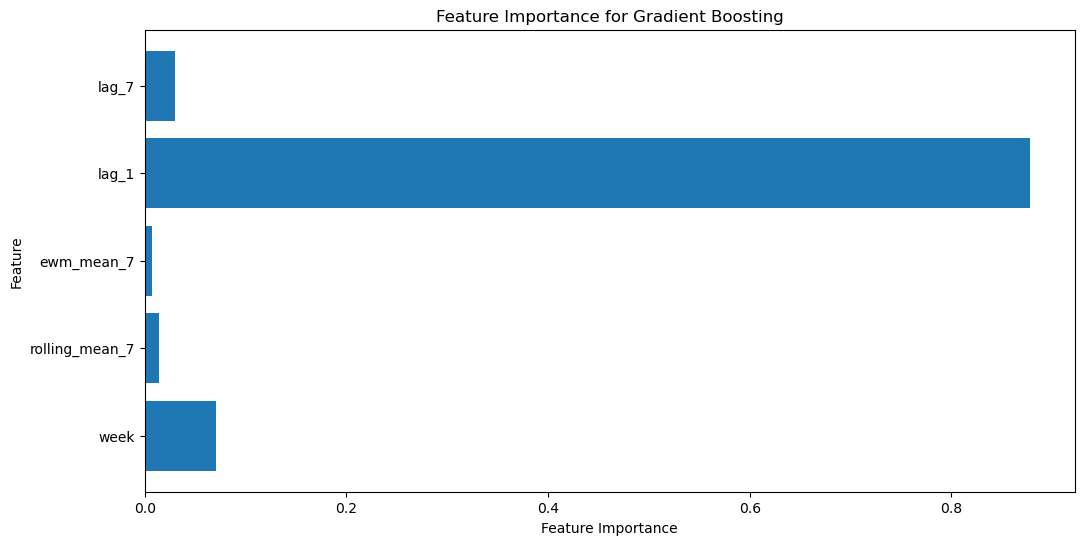

In [153]:
plt.figure(figsize=(12, 6))
plt.barh(X.columns, model_gb.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Gradient Boosting')
plt.show()

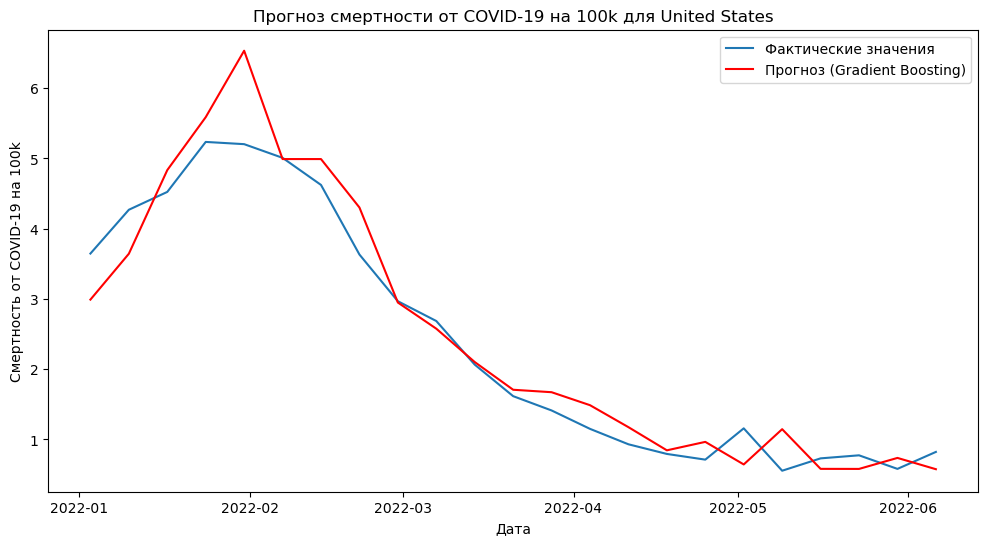

In [154]:
plt.figure(figsize=(12, 6))
plt.plot(region_df['start_date'].iloc[-len(y_test):], y_test, label='Фактические значения')
plt.plot(region_df['start_date'].iloc[-len(y_test):], y_pred_gb, label='Прогноз (Gradient Boosting)', color='red')
plt.legend()
plt.title(f'Прогноз смертности от COVID-19 на 100k для {selected_region}')
plt.xlabel('Дата')
plt.ylabel('Смертность от COVID-19 на 100k')
plt.show()

Модель градиентного бустинга показывает лучшие результаты на тестовой выборке по сравнению с моделью Arima.
ARIMA модель показывает низкое качество предсказаний, с отрицательными значениями как на кросс-валидации, так и на тестовой выборке, в то время как модель градиентного бустинга справляется хорошо

In [155]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
cv_scores_lr = cross_val_score(model_lr, X, y, cv=tscv, scoring='r2')
print(f'Cross-Validation R2 Scores for Linear Regression: {cv_scores_lr}')
print(f'Mean Cross-Validation R2 Score for Linear Regression: {cv_scores_lr.mean()}')

Cross-Validation R2 Scores for Linear Regression: [-0.07208315  0.7090008   0.96004524  0.29607057  0.95854798]
Mean Cross-Validation R2 Score for Linear Regression: 0.5703162856195179


In [156]:
y_pred_lr = model_lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
print(f'R2 Score for Linear Regression on Test Data: {r2_lr}')

R2 Score for Linear Regression on Test Data: 0.9461846772844509


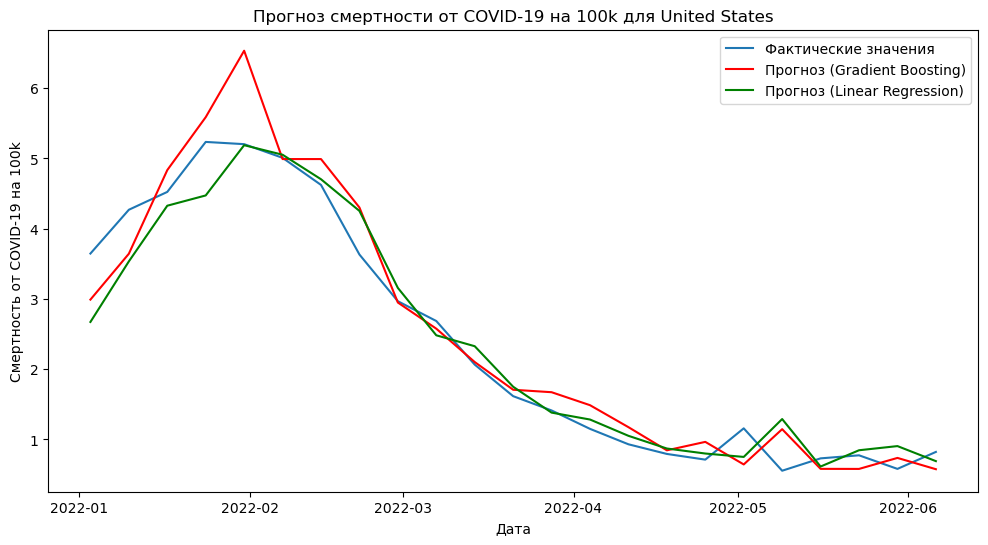

In [157]:
plt.figure(figsize=(12, 6))
plt.plot(region_df['start_date'].iloc[-len(y_test):], y_test, label='Фактические значения')
plt.plot(region_df['start_date'].iloc[-len(y_test):], y_pred_gb, label='Прогноз (Gradient Boosting)', color='red')
plt.plot(region_df['start_date'].iloc[-len(y_test):], y_pred_lr, label='Прогноз (Linear Regression)', color='green')
plt.legend()
plt.title(f'Прогноз смертности от COVID-19 на 100k для {selected_region}')
plt.xlabel('Дата')
plt.ylabel('Смертность от COVID-19 на 100k')
plt.show()